In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math as mt
import seaborn as sns
from datetime import date, time, datetime, timedelta
from IPython.display import clear_output
import scipy.stats as ss
from statistics import mode
import os
import sys
import multiprocessing as mp

In [2]:
cw_directory = os.getcwd()

growth_data_path = f"{cw_directory}//growth_db.csv"
weather_data_path = f"{cw_directory}//weather_db.csv"
zone_data_path = f"{cw_directory}//zone_db.csv"
    
growth_data = pd.read_csv(growth_data_path)
weather_data = pd.read_csv(weather_data_path)
zone_data = pd.read_csv(zone_data_path)

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
linearisation_coef = 0.7
stripping_coef = 0.92
min_grow_temp = 3
max_grow_temp = 27

In [5]:
weather_data['date'] = pd.to_datetime(weather_data['date'], format='%d/%m/%Y')
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%H:%M:%S')
weather_data['day'] = weather_data.date.dt.day
weather_data['month'] = weather_data.date.dt.month
weather_data['day_month'] = weather_data['day'].astype(str) + " - " + weather_data['month'].astype(str)
weather_data['heat_units'] = weather_data['avg_temp'] - min_grow_temp
weather_data['heat_units'] = np.where((weather_data['heat_units'] < 0), 0, weather_data['heat_units']/24)
weather_data['heat_units'] = np.where((weather_data['heat_units'] > 24), 24, weather_data['heat_units']/24)

In [6]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64383 entries, 0 to 64382
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             64383 non-null  datetime64[ns]
 1   time             64383 non-null  datetime64[ns]
 2   avg_temp         64383 non-null  float64       
 3   rh               64383 non-null  float64       
 4   rain             64383 non-null  float64       
 5   solar_radiation  64383 non-null  float64       
 6   wind_speed_avg   64383 non-null  float64       
 7   wind_speed_gust  8151 non-null   float64       
 8   soil_temp        8151 non-null   float64       
 9   bat_volt         64383 non-null  float64       
 10  leaf_wet         60962 non-null  float64       
 11  dew_point        60962 non-null  float64       
 12  day              64383 non-null  int64         
 13  month            64383 non-null  int64         
 14  day_month        64383 non-null  objec

In [7]:
weather_data.head()

,date,time,avg_temp,rh,rain,solar_radiation,wind_speed_avg,wind_speed_gust,soil_temp,bat_volt,leaf_wet,dew_point,day,month,day_month,heat_units
0,2014-05-14,1900-01-01 14:00:00,15.8,55.9,0.0,457.0,2.7,NaN,NaN,6904.0,0.0,7.2,14,5,14 - 5,0.022222
1,2014-05-14,1900-01-01 15:00:00,17.0,51.2,0.0,1212.0,2.2,NaN,NaN,6952.0,0.0,7.0,14,5,14 - 5,0.024306
2,2014-05-14,1900-01-01 16:00:00,17.3,48.9,0.0,862.0,2.1,NaN,NaN,6922.0,0.0,6.6,14,5,14 - 5,0.024826
3,2014-05-14,1900-01-01 17:00:00,17.5,48.9,0.0,611.0,2.0,NaN,NaN,6904.0,0.0,6.7,14,5,14 - 5,0.025174
4,2014-05-14,1900-01-01 18:00:00,16.8,51.0,0.0,232.0,1.7,NaN,NaN,6894.0,0.0,6.7,14,5,14 - 5,0.023958


In [8]:
growth_data['sample_date'] = pd.to_datetime(growth_data['sample_date'], format='%d/%m/%Y')
growth_data['fieldzone'] = growth_data["field"] + " - " + growth_data["zone"].astype(str)
growth_data['stripped_diameter'] = growth_data['diameter'] * stripping_coef

In [9]:
growth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116119 entries, 0 to 116118
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   sample_date        116119 non-null  datetime64[ns]
 1   field              116119 non-null  object        
 2   zone               116119 non-null  int64         
 3   diameter           116119 non-null  float64       
 4   fieldzone          116119 non-null  object        
 5   stripped_diameter  116119 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 5.3+ MB


In [10]:
growth_data.head()

,sample_date,field,zone,diameter,fieldzone,stripped_diameter
0,2019-07-17,Allans 18,1,4.0,Allans 18 - 1,3.68
1,2019-07-17,Allans 18,1,3.0,Allans 18 - 1,2.76
2,2019-07-17,Allans 18,1,5.0,Allans 18 - 1,4.60
3,2019-07-17,Allans 18,1,5.0,Allans 18 - 1,4.60
4,2019-07-17,Allans 18,1,3.0,Allans 18 - 1,2.76


In [11]:
zone_data['planting_date'] = pd.to_datetime(zone_data['planting_date'], format='%d/%m/%Y')
zone_data['harvest_date'] = pd.to_datetime(zone_data['harvest_date'], format='%d/%m/%Y')
zone_data['zone'] = zone_data['zone'].astype(int)
zone_data["fieldzone"] = zone_data["field"] + " - " + zone_data["zone"].astype(str)
zone_data["fieldvariety"] = zone_data["field"] + " - " + zone_data["variety"]

In [12]:
zone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   field           755 non-null    object        
 1   zone            755 non-null    int32         
 2   planting_date   755 non-null    datetime64[ns]
 3   variety         755 non-null    object        
 4   method          755 non-null    object        
 5   inputs          755 non-null    object        
 6   protection      755 non-null    object        
 7   planting_rate   755 non-null    int64         
 8   sand            755 non-null    int64         
 9   silt            755 non-null    int64         
 10  clay            755 non-null    int64         
 11  organic_matter  755 non-null    float64       
 12  harvest_date    490 non-null    datetime64[ns]
 13  fieldzone       755 non-null    object        
 14  fieldvariety    755 non-null    object        
dtypes: dat

In [13]:
zone_data.head()

,field,zone,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldzone,fieldvariety
0,Allans 07,1,2019-04-01,Krypton,Drilled,Conventional,Barley,249820,39,37,24,29.6,2019-12-15,Allans 07 - 1,Allans 07 - Krypton
1,Allans 07,2,2019-04-01,Krypton,Drilled,Conventional,Barley,249820,39,37,24,29.6,2019-12-15,Allans 07 - 2,Allans 07 - Krypton
2,Allans 07,3,2019-04-01,Longton,Drilled,Conventional,Barley,256524,39,37,24,29.6,2019-12-15,Allans 07 - 3,Allans 07 - Longton
3,Allans 07,4,2019-04-01,Longton,Drilled,Conventional,Barley,256524,39,37,24,29.6,2019-12-15,Allans 07 - 4,Allans 07 - Longton
4,Allans 07,5,2019-04-01,Batter,Drilled,Conventional,Barley,247048,39,37,24,29.6,2019-12-15,Allans 07 - 5,Allans 07 - Batter


In [14]:
summary_data = growth_data

summary_data["zone"] = summary_data["zone"].astype(str)
summary_data["fieldzone"] = summary_data["field"] + " - " + summary_data["zone"]
summary_data['fieldzonedate'] = summary_data['fieldzone'] + " - " + summary_data['sample_date'].astype(str)

summary_data = summary_data.set_index('fieldzone')
summary_data = summary_data.join(zone_data.set_index('fieldzone'), rsuffix = '_join')

summary_data['heat_units'] = 0
summary_data['solar_radiation'] = 0

summary_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116119 entries, Allans 06 - 1 to Wissey O (S) - 3
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   sample_date        116119 non-null  datetime64[ns]
 1   field              116119 non-null  object        
 2   zone               116119 non-null  object        
 3   diameter           116119 non-null  float64       
 4   stripped_diameter  116119 non-null  float64       
 5   fieldzonedate      116119 non-null  object        
 6   field_join         115823 non-null  object        
 7   zone_join          115823 non-null  float64       
 8   planting_date      115823 non-null  datetime64[ns]
 9   variety            115823 non-null  object        
 10  method             115823 non-null  object        
 11  inputs             115823 non-null  object        
 12  protection         115823 non-null  object        
 13  planting_rate      115823 n

In [15]:
summary_data.head()

,sample_date,field,zone,diameter,stripped_diameter,fieldzonedate,field_join,zone_join,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldvariety,heat_units,solar_radiation
fieldzone,,,,,,,,,,,,,,,,,,,,,,
Allans 06 - 1,2021-07-29,Allans 06,1,13.0,11.96,Allans 06 - 1 - 2021-07-29,Allans 06,1.0,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0
Allans 06 - 1,2021-07-29,Allans 06,1,14.0,12.88,Allans 06 - 1 - 2021-07-29,Allans 06,1.0,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0
Allans 06 - 1,2021-07-29,Allans 06,1,8.0,7.36,Allans 06 - 1 - 2021-07-29,Allans 06,1.0,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0
Allans 06 - 1,2021-07-29,Allans 06,1,10.0,9.20,Allans 06 - 1 - 2021-07-29,Allans 06,1.0,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0
Allans 06 - 1,2021-07-29,Allans 06,1,7.0,6.44,Allans 06 - 1 - 2021-07-29,Allans 06,1.0,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0


In [16]:
summary_data = summary_data.reset_index(inplace=False)
summary_data = summary_data.drop(columns=['field_join', 'zone_join'], inplace=False)
summary_data.head()

,fieldzone,sample_date,field,zone,diameter,stripped_diameter,fieldzonedate,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldvariety,heat_units,solar_radiation
0,Allans 06 - 1,2021-07-29,Allans 06,1,13.0,11.96,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0
1,Allans 06 - 1,2021-07-29,Allans 06,1,14.0,12.88,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0
2,Allans 06 - 1,2021-07-29,Allans 06,1,8.0,7.36,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0
3,Allans 06 - 1,2021-07-29,Allans 06,1,10.0,9.20,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0
4,Allans 06 - 1,2021-07-29,Allans 06,1,7.0,6.44,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270.0,40.0,41.0,19.0,24.6,NaT,Allans 06 - Krypton,0,0


In [17]:

def skewness(series):
    return ss.skew(series, bias = False)

def kurt(series):
    return ss.kurtosis(series, bias = False)

In [18]:
summary_data_avg = summary_data.groupby(['fieldzonedate']).agg({'stripped_diameter' : ['mean', 'std', 'count', skewness, kurt],
                                                                'method' : ['first'],
                                                                'inputs' : ['first'],
                                                                'variety' : ['first'],
                                                                'protection' : ['first'],
                                                                'sand' : ['mean'],
                                                                'silt' : ['mean'],
                                                                'clay' : ['mean'],
                                                                'organic_matter' : ['mean'],
                                                                'planting_date' : ['first'],
                                                                'sample_date' : ['first'],
                                                                'fieldzone' : ['first']}).reset_index()

summary_data_avg.columns = ['fieldzonedate',
                            'mean_diameter',
                            'std_dev_diameter',
                            'pp2m2',
                            'skewness',
                            'kurtosis',
                            'method',
                            'inputs',
                            'variety',
                            'protection',
                            'sand',
                            'silt',
                            'clay',
                            'organic_matter',
                            'planting_date',
                            'sample_date',
                            'fieldzone']

summary_data_avg['d_lin'] = (summary_data_avg['mean_diameter'])**linearisation_coef
summary_data_avg['s_lin'] = (summary_data_avg['std_dev_diameter'])**linearisation_coef
summary_data_avg['heat_units'] = 0
summary_data_avg['solar_radiation'] = 0

summary_data_avg.tail()

,fieldzonedate,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,method,inputs,variety,protection,sand,silt,clay,organic_matter,planting_date,sample_date,fieldzone,d_lin,s_lin,heat_units,solar_radiation
2942,Wissey O (S) - 1 - 2019-09-19,34.209474,5.277874,38,-0.366295,-0.436126,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,2019-03-26,2019-09-19,Wissey O (S) - 1,11.855025,3.204212,0,0
2943,Wissey O (S) - 2 - 2019-07-30,18.447179,3.409484,39,0.261426,0.527252,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,2019-03-26,2019-07-30,Wissey O (S) - 2,7.693979,2.359837,0,0
2944,Wissey O (S) - 2 - 2019-09-19,30.631818,4.797228,44,-0.065718,-0.292600,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,2019-03-26,2019-09-19,Wissey O (S) - 2,10.972888,2.997045,0,0
2945,Wissey O (S) - 3 - 2019-07-30,20.079000,2.996661,40,0.333063,-0.493385,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,2019-03-26,2019-07-30,Wissey O (S) - 3,8.164309,2.155988,0,0
2946,Wissey O (S) - 3 - 2019-09-19,29.920909,3.829350,44,-0.133634,-0.709054,Drilled,Conventional,Shafton,Barley,11.0,64.0,25.0,71.2,2019-03-26,2019-09-19,Wissey O (S) - 3,10.793998,2.559691,0,0


In [19]:
weather_data_avg = weather_data.groupby(['date']).agg({'rain' : ['sum'],
                                                       'heat_units' : ['sum'],
                                                       'solar_radiation' : ['sum'],
                                                       'wind_speed_avg' : ['mean'],
                                                       'rh' : ['mean'],
                                                       'avg_temp' : ['mean']}).reset_index()

weather_data_avg.columns = ['date',
                            'rain',
                            'heat_units',
                            'solar_radiation',
                            'wind_speed_avg',
                            'rh',
                            'avg_temp']

weather_data_avg['day'] = weather_data_avg.date.dt.day
weather_data_avg['month'] = weather_data_avg.date.dt.month
weather_data_avg['day_month'] = weather_data_avg['day'].astype(str) + " - " + weather_data_avg['month'].astype(str)  

weather_data_avg_group = weather_data_avg.groupby(['day_month']).agg({'rain' : ['mean'],
                                                                      'heat_units' : ['mean'],
                                                                      'solar_radiation' : ['mean'],
                                                                      'wind_speed_avg' : ['mean'],
                                                                      'rh' : ['mean'],
                                                                      'avg_temp' : ['mean']}).reset_index()
weather_data_avg_group.columns = ['day_month',
                                  'rain',
                                  'heat_units',
                                  'solar_radiation',
                                  'wind_speed_avg',
                                  'rh',
                                  'avg_temp']

max_date = max(weather_data_avg.date)

for i in range(1, 300):
    
    clear_output(wait=True)
    
    date = max_date + timedelta(days=i)
    weather_data_avg = weather_data_avg.append({'date': date,
                                                'rain': np.nan,
                                                'heat_units':np.nan,
                                                'solar_radiation':np.nan,
                                                'wind_speed_avg':np.nan,
                                                'rh':np.nan,
                                                'avg_temp':np.nan }, ignore_index=True)
    
    print("Current Progress:", np.round(i/300*100,0),"%")
    
weather_data_avg['day'] = weather_data_avg.date.dt.day
weather_data_avg['month'] = weather_data_avg.date.dt.month
weather_data_avg['day_month'] = weather_data_avg['day'].astype(str) + " - " + weather_data_avg['month'].astype(str)  

Current Progress: 100.0 %


In [20]:

###THIS IS A VERY SLOW PROCESS (COULD PARALLEL PROCESSING BE INTRODUCED)

def mean_weather(day_month, variable):
    
    df = weather_data_avg_group[weather_data_avg_group['day_month']==day_month]
    weather_value = df[variable].sum()
    return weather_value

for variable in ['rain', 'heat_units', 'solar_radiation', 'wind_speed_avg', 'rh', 'avg_temp']:
    for i in weather_data_avg.index:
        clear_output(wait=True)
        if weather_data_avg[variable][i] == np.nan:
            test = 'test'
        else:
            day_month = weather_data_avg['day_month'][i]
            weather_data_avg[variable][i] = mean_weather(day_month, variable)
        print(f"{variable} progress:", np.round(i/len(weather_data_avg)*100,0),"%")
    
weather_data_avg.tail()

avg_temp progress: 100.0 %


,date,rain,heat_units,solar_radiation,wind_speed_avg,rh,avg_temp,day,month,day_month
2978,2022-07-09,1.650,0.593511,9160.020,2.459792,82.161458,17.244271,9,7,9 - 7
2979,2022-07-10,2.650,0.575022,9061.445,2.381875,82.161458,16.800521,10,7,10 - 7
2980,2022-07-11,4.500,0.555208,8404.790,2.905833,84.598438,16.325000,11,7,11 - 7
2981,2022-07-12,4.000,0.554774,9027.575,2.618750,84.129167,16.314583,12,7,12 - 7
2982,2022-07-13,1.425,0.551345,8193.480,3.074740,84.304167,16.232292,13,7,13 - 7


In [21]:
###COULD CUM FUNCTIONS BE VECTORISED???PASS ARRAY TO FUNCTION INSTEAD OF SINGLE VALUE

def cum_heat_units(start, finish, weather_data):
    df = weather_data_avg.loc[(weather_data_avg['date'] > start) & (weather_data_avg['date'] < finish), ['heat_units']]
    total_hu = df['heat_units'].sum()
    return total_hu

def cum_solar_radiation(start, finish, weather_data = weather_data):
    df = weather_data.loc[(weather_data['date'] > start) & (weather_data['date'] < finish), ['solar_radiation']]
    total_sr = df['solar_radiation'].sum()
    return total_sr

In [22]:
for i in summary_data_avg.index:
    clear_output(wait=True)
    planting_date = summary_data_avg['planting_date'][i]
    sample_date = summary_data_avg['sample_date'][i]
    summary_data_avg['solar_radiation'][i] = cum_solar_radiation(planting_date, sample_date, weather_data_avg)
    print("Current Progress:", np.round(i/len(summary_data_avg)*100,0),"%")

Current Progress: 100.0 %


In [23]:
for i in summary_data_avg.index:
    clear_output(wait=True)
    planting_date = summary_data_avg['planting_date'][i]
    sample_date = summary_data_avg['sample_date'][i]
    summary_data_avg['heat_units'][i] = cum_heat_units(planting_date, sample_date, weather_data_avg)
    print("Current Progress:", np.round(i/len(summary_data_avg)*100,0),"%")

Current Progress: 100.0 %


def heat_units_received(summary_data_avg):
    for i in summary_data_avg.index:
        clear_output(wait=True)
        planting_date = summary_data_avg['planting_date'][i]
        sample_date = summary_data_avg['sample_date'][i]
        summary_data_avg['heat_units'][i] = cum_heat_units(planting_date, sample_date, weather_data_avg)
        print("Current Progress:", np.round(i/len(summary_data_avg)*100,0),"%")


def process_chunk(proc_chunk):
    """
    Process the partial array/dataframe `proc_chunk` passed to this process worker.
    Return an array/dataframe of the same length and same indices.
    """

    chunk_res = heat_units_received(proc_chunk)
    chunk_res.index = proc_chunk.index
    
    return chunk_res

# set the number of processes
n_proc = mp.cpu_count()

# this often can't be devided evenly (handle this in the for-loop below)
chunksize = len(summary_data_avg.index) // n_proc

# devide into chunks
proc_chunks = []
for i_proc in range(n_proc):
    chunkstart = i_proc * chunksize
    # make sure to include the division remainder for the last process
    chunkend = (i_proc + 1) * chunksize if i_proc < n_proc - 1 else None

    proc_chunks.append(summary_data_avg.iloc[slice(chunkstart, chunkend)])

assert sum(map(len, proc_chunks)) == len(summary_data_avg.index)   # make sure all data is in the chunks

print('x')

# distribute work to the worker processes
with mp.Pool(processes=n_proc) as pool:
    # starts the sub-processes without blocking
    # pass the chunk to each worker process
    proc_results = [pool.apply_async(process_chunk, args=(chunk,)) for chunk in proc_chunks]

    # blocks until all results are fetched
    result_chunks = [r.get() for r in proc_results]

    # concatenate results from worker processes
    results = pd.concat(result_chunks)
    
print('x')

results = pd.concat((summary_data_avg, results), axis=1)
assert len(results) == len(summary_data_avg.index)   # make sure we got a result for each coordinate pair

In [24]:
summary_data_avg = pd.get_dummies(summary_data_avg, columns = ['protection'], drop_first = True)

In [25]:
summary_data_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fieldzonedate      2947 non-null   object        
 1   mean_diameter      2947 non-null   float64       
 2   std_dev_diameter   2947 non-null   float64       
 3   pp2m2              2947 non-null   int64         
 4   skewness           2947 non-null   float64       
 5   kurtosis           2947 non-null   float64       
 6   method             2940 non-null   object        
 7   inputs             2940 non-null   object        
 8   variety            2940 non-null   object        
 9   sand               2940 non-null   float64       
 10  silt               2940 non-null   float64       
 11  clay               2940 non-null   float64       
 12  organic_matter     2940 non-null   float64       
 13  planting_date      2940 non-null   datetime64[ns]
 14  sample_d

In [26]:
summary_data_avg[summary_data_avg.isna().any(axis=1)]

,fieldzonedate,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,method,inputs,variety,sand,silt,clay,organic_matter,planting_date,sample_date,fieldzone,d_lin,s_lin,heat_units,solar_radiation,protection_Fleece,protection_None,protection_Poly
517,Grotec Far Black - 1 - 2021-09-02,14.495111,4.417200,45,0.100887,-0.022653,None,None,None,NaN,NaN,NaN,NaN,NaT,2021-09-02,Grotec Far Black - 1,6.499128,2.828805,0,0,0,0,0
518,Grotec Far Black - 2 - 2021-09-02,14.506047,3.953693,43,-0.676530,0.563474,None,None,None,NaN,NaN,NaN,NaN,NaT,2021-09-02,Grotec Far Black - 2,6.502560,2.617593,0,0,0,0,0
519,Grotec Far Black - 3 - 2021-09-02,16.761951,5.181945,41,-0.062527,-0.202465,None,None,None,NaN,NaN,NaN,NaN,NaT,2021-09-02,Grotec Far Black - 3,7.194940,3.163333,0,0,0,0,0
520,Grotec Far Black - 4 - 2021-09-02,13.991667,4.136011,48,0.364531,-0.026108,None,None,None,NaN,NaN,NaN,NaN,NaT,2021-09-02,Grotec Far Black - 4,6.340283,2.701514,0,0,0,0,0
521,Grotec Far Black - 5 - 2021-09-02,17.270909,5.537316,44,0.090799,-0.159161,None,None,None,NaN,NaN,NaN,NaN,NaT,2021-09-02,Grotec Far Black - 5,7.347179,3.313672,0,0,0,0,0
522,Grotec Far Black - 6 - 2021-09-02,11.752258,4.001099,31,0.342965,-0.413449,None,None,None,NaN,NaN,NaN,NaN,NaT,2021-09-02,Grotec Far Black - 6,5.611577,2.639523,0,0,0,0,0
523,Grotec Far Black - 7 - 2021-09-02,13.319091,4.874198,44,0.572751,0.995455,None,None,None,NaN,NaN,NaN,NaN,NaT,2021-09-02,Grotec Far Black - 7,6.125368,3.030625,0,0,0,0,0


In [27]:
summary_data_avg = summary_data_avg.dropna()

In [28]:
from sklearn.ensemble import IsolationForest

print(f"The old training dataframe shape: {summary_data_avg.shape}")

iso = IsolationForest(bootstrap = True)
preds = iso.fit_predict(summary_data_avg[['d_lin',
                                          's_lin',
                                          'pp2m2',
                                          'sand',
                                          'silt',
                                          'clay',
                                          'organic_matter',
                                          'heat_units',
                                          'solar_radiation',]]
                        )

totalOutliers=0

for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
        
print("Total number of outliers identified is: ",totalOutliers)

filtered_array = []
unfiltered_array = []
for element in preds:
  if element != -1:
    filtered_array.append(True)
    unfiltered_array.append(False)
  else:
    filtered_array.append(False)
    unfiltered_array.append(True)

summary_data_avg_outliers = summary_data_avg[unfiltered_array]

summary_data_avg = summary_data_avg[filtered_array]

print(f"The new training dataframe shape: {summary_data_avg.shape}")

The old training dataframe shape: (2940, 23)
Total number of outliers identified is:  694
The new training dataframe shape: (2246, 23)


In [29]:
summary_data_avg_outliers

,fieldzonedate,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,method,inputs,variety,sand,silt,clay,organic_matter,planting_date,sample_date,fieldzone,d_lin,s_lin,heat_units,solar_radiation,protection_Fleece,protection_None,protection_Poly
21,Allans 07 - 1 - 2020-01-13,35.220667,10.502927,42,-0.134837,0.285760,Drilled,Conventional,Krypton,39.0,37.0,24.0,29.6,2019-04-01,2020-01-13,Allans 07 - 1,12.099246,5.187012,106,1758282,0,0,0
25,Allans 07 - 2 - 2020-01-13,36.267368,9.562431,38,-0.226877,-0.893282,Drilled,Conventional,Krypton,39.0,37.0,24.0,29.6,2019-04-01,2020-01-13,Allans 07 - 2,12.349837,4.857333,106,1758282,0,0,0
76,Allans 12 - 1 - 2021-04-05,25.560000,6.021650,46,-0.425058,-0.471269,Drilled,Conventional,Longton,27.0,45.0,28.0,32.8,2020-05-02,2021-04-05,Allans 12 - 1,9.667020,3.513993,109,1771451,0,0,0
83,Allans 12 - 2 - 2021-04-05,23.274043,6.312786,47,-0.393189,-0.457389,Drilled,Conventional,Longton,27.0,45.0,28.0,32.8,2020-05-02,2021-04-05,Allans 12 - 2,9.053370,3.632075,109,1771451,0,0,0
90,Allans 12 - 3 - 2021-04-05,27.307273,7.199859,44,-0.090618,-0.274072,Drilled,Conventional,Longton,27.0,45.0,28.0,32.8,2020-05-02,2021-04-05,Allans 12 - 3,10.124995,3.982234,109,1771451,0,0,0
97,Allans 12 - 4 - 2021-04-05,23.726316,6.737400,38,-0.127436,-1.097880,Drilled,Conventional,Longton,27.0,45.0,28.0,32.8,2020-05-02,2021-04-05,Allans 12 - 4,9.176165,3.801409,109,1771451,0,0,0
104,Allans 16/17 - 1 - 2021-04-05,29.858182,6.524883,44,-0.602729,-0.132732,Drilled,Conventional,Lexton,25.0,44.0,31.0,36.4,2020-05-03,2021-04-05,Allans 16/17 - 1,10.778153,3.717071,109,1764675,0,0,0
111,Allans 16/17 - 2 - 2021-04-05,26.526667,3.647230,48,-0.814030,1.758996,Drilled,Conventional,Batter,35.0,38.0,27.0,23.8,2020-05-03,2021-04-05,Allans 16/17 - 2,9.921512,2.473855,109,1764675,0,0,0
135,Allans 16/17 - 6 - 2021-04-05,28.185455,6.995521,44,-0.769495,-0.189949,Drilled,Conventional,Lexton,25.0,44.0,31.0,36.4,2020-05-05,2021-04-05,Allans 16/17 - 6,10.351840,3.902780,108,1742656,0,0,0
136,Allans 18 - 1 - 2019-07-17,3.618667,1.026719,45,0.239111,0.768573,Drilled,Conventional,Lexton,31.0,36.0,33.0,19.9,2019-04-23,2019-07-17,Allans 18 - 1,2.460277,1.018629,38,833405,0,0,0


In [30]:
X = summary_data_avg.drop(['d_lin',
                           's_lin',
                           'mean_diameter',
                           'std_dev_diameter',
                           'skewness',
                           'kurtosis',
                           'fieldzonedate',
                           'sample_date',
                           'planting_date',
                           'sand',
                           'silt',
                           'clay',
                           'fieldzone'], axis = 1)

y = summary_data_avg['d_lin']

In [31]:
X = pd.get_dummies(X, columns = ['method',
                                 'inputs',
                                 'variety'], drop_first = True)

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression

### NEED TO FIGURE OUT HOW TO SCALE DATA
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

reg = LinearRegression(normalize=True).fit(X, y)
preds = reg.predict(X)
summary_data_avg['preds'] = preds
print(reg.score(X, y))

0.8312896808151504


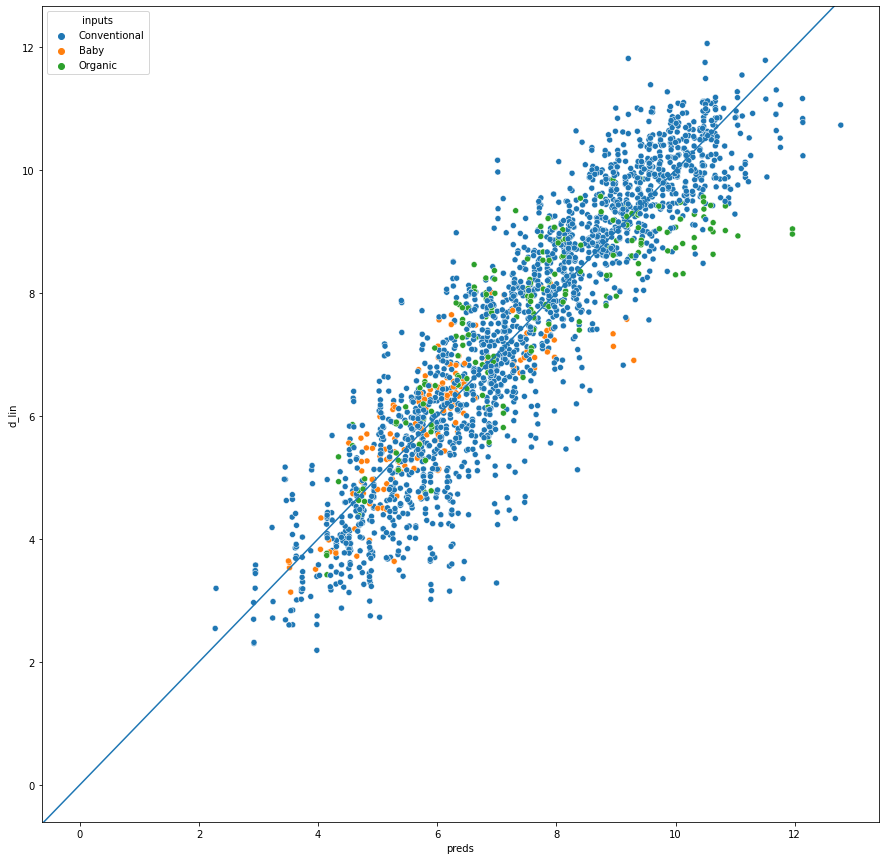

In [33]:
plt.figure(figsize=(15,15))
sns.scatterplot(x = 'preds', y = 'd_lin', data = summary_data_avg, hue = 'inputs')
plt.axline([0, 0], [1, 1])
plt.show()

In [34]:
coef_list = list(reg.coef_)
var_list = list(X)

reg_coef_df = pd.DataFrame({'variable': var_list,
                            'coef': coef_list}, columns=['variable',
                                                         'coef'])

reg_coef_df

,variable,coef
0,pp2m2,0.001288
1,organic_matter,0.027835
2,heat_units,0.060053
3,solar_radiation,0.000004
4,protection_Fleece,0.965736
5,protection_None,0.402454
6,protection_Poly,1.721922
7,method_Blocks,-1.790964
8,method_Drilled,-5.019992
9,method_Modules,-0.876448


In [35]:
def average_count(fieldzone, df_1 = summary_data_avg):
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    average_count = df_1['pp2m2'].mean()
    
    if mt.isnan(average_count):
        average_count = 40
      
    return average_count

average_count('RH33 - 1')

37.0

In [36]:
def max_sample_date(fieldzone, df_1 = summary_data_avg, df_2 = zone_data):
    
    df_1 = df_1[df_1['fieldzone'] == fieldzone]
    max_sample_date = max(df_1['sample_date'], default = 0)
    if max_sample_date == 0:
        df_2 = df_2[df_2['fieldzone'] == fieldzone]
        max_sample_date = df_2['planting_date'].max()
    
    return max_sample_date

max_sample_date('RH33 - 1')

Timestamp('2021-09-15 00:00:00')

In [37]:
def max_mean_diameter_lin(fieldzone, df_1 = summary_data_avg):
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_mean_diameter = df_1['mean_diameter'].max()
    max_mean_diameter_lin = max_mean_diameter ** linearisation_coef
    
    if mt.isnan(max_mean_diameter_lin):
        max_mean_diameter_lin = 0
    
    return max_mean_diameter_lin

max_mean_diameter_lin('Allans 07 - 1')

12.0576025343151

In [38]:
def max_std_dev_diameter_lin(fieldzone, df_1 = summary_data_avg):
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_std_dev_diameter = df_1['std_dev_diameter'].max()
    max_std_dev_diameter_lin = max_std_dev_diameter ** linearisation_coef
    
    if mt.isnan(max_std_dev_diameter_lin):
        max_std_dev_diameter_lin = 0
    
    return max_std_dev_diameter_lin

max_std_dev_diameter_lin('Allans 07 - 1')

4.049213381424413

In [39]:
def max_solar(fieldzone, df_1 = summary_data_avg):
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_solar = df_1['solar_radiation'].max()
    
    if mt.isnan(max_solar):
        max_solar = 0
    
    return max_solar

max_solar('Allans 07 - 1')

1664167

In [40]:
def max_heat(fieldzone, df_1 = summary_data_avg):
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_heat = df_1['heat_units'].max()
    
    if mt.isnan(max_heat):
        max_heat = 0
    
    return max_heat

max_heat('Allans 07 - 1')

94

In [41]:
def filter_data(data, method, inputs, variety):
    
    filtered = data[data['variety'].str.contains(variety)]
    filtered = filtered[filtered['inputs'].str.contains(inputs)]
    filtered = filtered[filtered['method'].str.contains(method)]
    
    return filtered

In [42]:
def predict_weather(start, finish, variable, df_1 = weather_data):
    
    df_1 = df_1.loc[(df_1['date'] > start) & (df_1['date'] < finish), [variable]]
    predicted_weather= df_1[variable].sum()
    
    return predicted_weather

start = datetime(year=2021, month=6, day=2, hour=13, minute=14, second=31)
finish = datetime(year=2022, month=6, day=2, hour=13, minute=14, second=31)

predict_weather(start, finish, 'rain')

253.0

In [43]:
zone_data['mean_pp2m2'] = 0.0
zone_data['max_sample_date'] = 0
zone_data['max_mean_diameter_lin'] = 0.0
zone_data['max_std_dev_diameter_lin'] = 0.0
zone_data['max_heat'] = 0.0
zone_data['max_solar'] = 0.0
zone_data['remaining_heat'] = 0.0
zone_data['remaining_solar'] = 0.0

for i in zone_data.index:
    
    clear_output(wait=True)
    
    fieldzone = zone_data.loc[i, 'fieldzone']
    zone_data.loc[i, 'mean_pp2m2'] = average_count(fieldzone)
    zone_data.loc[i, 'max_sample_date'] = max_sample_date(fieldzone)
    zone_data.loc[i, 'max_mean_diameter_lin'] = max_mean_diameter_lin(fieldzone)
    zone_data.loc[i, 'max_std_dev_diameter_lin'] = max_std_dev_diameter_lin(fieldzone)
    zone_data.loc[i, 'max_heat'] = max_heat(fieldzone)
    zone_data.loc[i, 'max_solar'] = max_solar(fieldzone)
    start = zone_data.loc[i, 'max_sample_date']
    today = datetime.today() ### + timedelta(days=7) if you want a week in the future.
    finish = today.strftime("%d/%m/%Y")
    zone_data.loc[i, 'remaining_heat'] = cum_heat_units(start, finish, weather_data_avg)
    zone_data.loc[i, 'remaining_solar'] = cum_solar_radiation(start, finish, weather_data_avg)   
    
    print("Current Progress:", np.round(i/len(zone_data)*100,0),"%")

Current Progress: 100.0 %


In [44]:
zone_data['est_mean_diameter_gain'] = 0.0
zone_data['est_std_dev_diameter_gain'] = 0.0

for i in zone_data.index:
    try:
        method = zone_data.loc[i, 'method']
        inputs = zone_data.loc[i, 'inputs']
        variety = zone_data.loc[i, 'variety']
        protection = zone_data.loc[i, 'protection']

        df = filter_data(summary_data_avg, method, inputs, variety)
        X = df[['solar_radiation', 'heat_units', 'pp2m2', 'organic_matter', 'protection_Fleece', 'protection_None', 'protection_Poly']]
        y_dl = df['d_lin']
        y_sd = df['s_lin']

        reg_dl = LinearRegression().fit(X, y_dl)
        solar_radiation_dl_coef = reg_dl.coef_[0]
        heat_units_dl_coef = reg_dl.coef_[1]

        reg_sd = LinearRegression().fit(X, y_sd) 
        solar_radiation_sd_coef = reg_sd.coef_[0]
        heat_units_sd_coef = reg_sd.coef_[1]

        zone_data.loc[i, 'est_mean_diameter_gain'] = (solar_radiation_dl_coef*(zone_data.loc[i, 'remaining_solar'])) + (heat_units_dl_coef*(zone_data.loc[i, 'remaining_heat']))
        zone_data.loc[i, 'est_std_dev_diameter_gain'] = (solar_radiation_sd_coef*(zone_data.loc[i, 'remaining_solar'])) + (heat_units_sd_coef*(zone_data.loc[i, 'remaining_heat']))
    except:
        zone_data.loc[i, 'est_mean_diameter_gain'] = 0
        zone_data.loc[i, 'est_std_dev_diameter_gain'] = 0
    

In [45]:
zone_data['est_mean_diameter'] = (zone_data['max_mean_diameter_lin'] + zone_data['est_mean_diameter_gain'])**(1/linearisation_coef)
zone_data['est_std_dev_diameter'] = (zone_data['max_std_dev_diameter_lin'] + zone_data['est_std_dev_diameter_gain'])**(1/linearisation_coef)
zone_data['field_variety'] = zone_data['field'] + " - " + zone_data['variety']
print(zone_data.info())
zone_data.to_csv('prediction_db.csv', index = False)
zone_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   field                      755 non-null    object        
 1   zone                       755 non-null    int32         
 2   planting_date              755 non-null    datetime64[ns]
 3   variety                    755 non-null    object        
 4   method                     755 non-null    object        
 5   inputs                     755 non-null    object        
 6   protection                 755 non-null    object        
 7   planting_rate              755 non-null    int64         
 8   sand                       755 non-null    int64         
 9   silt                       755 non-null    int64         
 10  clay                       755 non-null    int64         
 11  organic_matter             755 non-null    float64       
 12  harvest_

,field,zone,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldzone,fieldvariety,mean_pp2m2,max_sample_date,max_mean_diameter_lin,max_std_dev_diameter_lin,max_heat,max_solar,remaining_heat,remaining_solar,est_mean_diameter_gain,est_std_dev_diameter_gain,est_mean_diameter,est_std_dev_diameter,field_variety
750,RH33,8,2021-07-23,Laston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 8,RH33 - Laston,37.0,2021-09-15 00:00:00,3.491871,1.095830,29.0,398578.0,6.052734,73596.257143,0.000000,0.000000,5.967568,1.139662,RH33 - Laston
751,RH33,9,2021-07-23,Laston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 9,RH33 - Laston,38.0,2021-09-15 00:00:00,3.931615,1.441240,29.0,398578.0,6.052734,73596.257143,0.000000,0.000000,7.069474,1.685645,RH33 - Laston
752,RH33,10,2021-08-01,Harston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 10,RH33 - Harston,37.0,2021-09-15 00:00:00,4.354591,1.674639,23.0,315876.0,6.052734,73596.257143,0.541608,0.135080,9.671927,2.333544,RH33 - Harston
753,RH33,11,2021-08-01,Harston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 11,RH33 - Harston,40.0,2021-08-01 00:00:00,0.000000,0.000000,0.0,0.0,30.526780,395531.842143,2.697547,0.708011,4.127338,0.610621,RH33 - Harston
754,RH33,12,2021-08-01,Harston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 12,RH33 - Harston,35.0,2021-09-15 00:00:00,4.124569,1.306204,23.0,315876.0,6.052734,73596.257143,0.541608,0.135080,9.029401,1.685718,RH33 - Harston


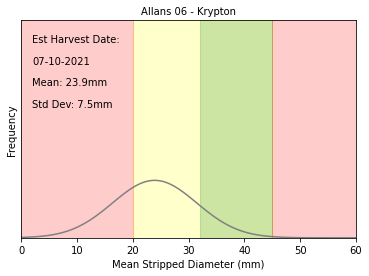

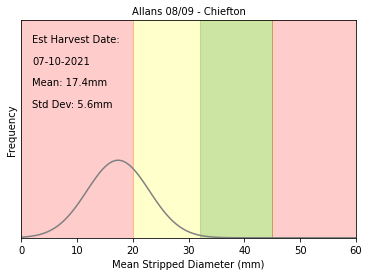

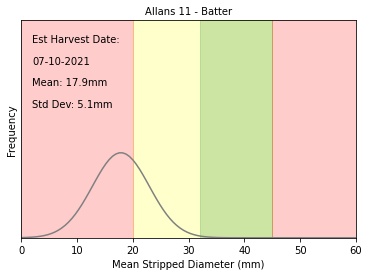

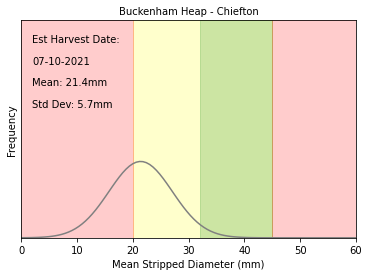

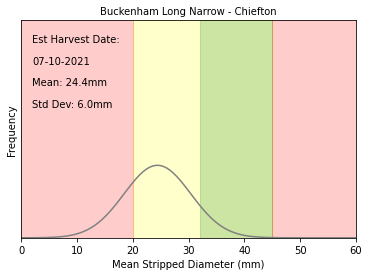

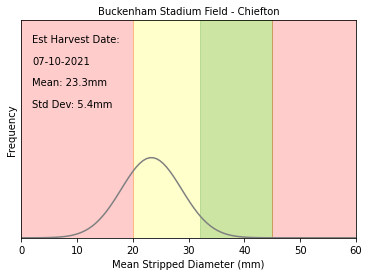

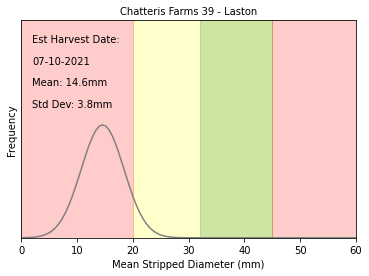

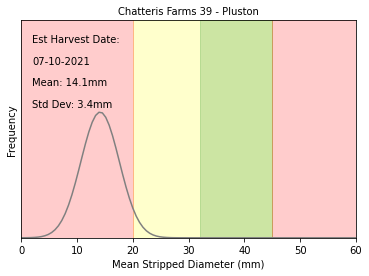

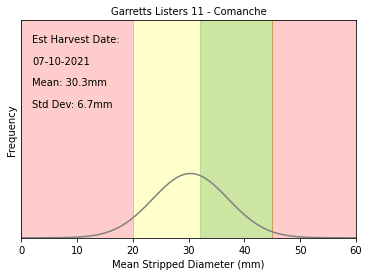

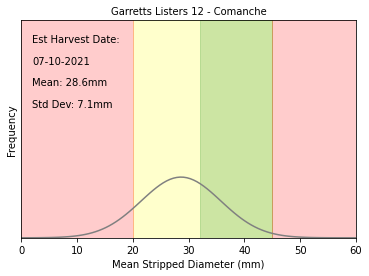

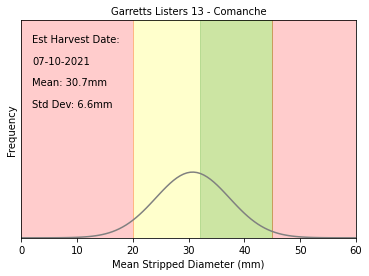

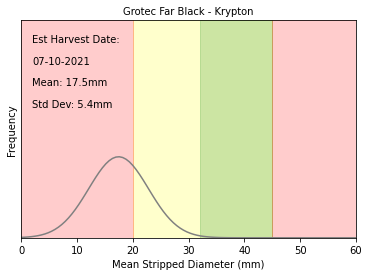

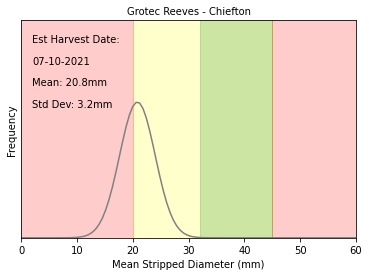

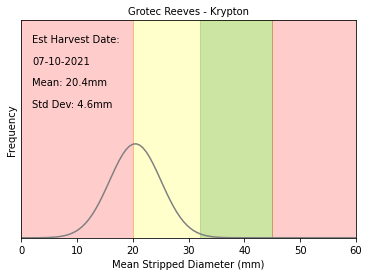

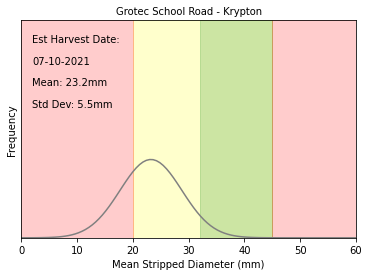

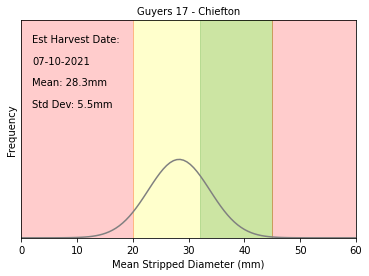

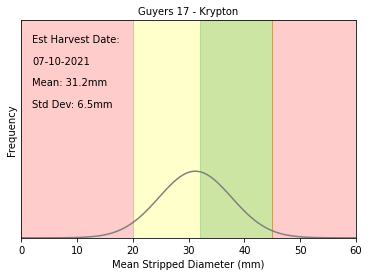

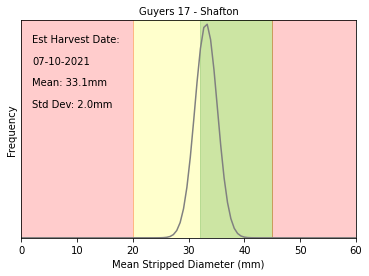

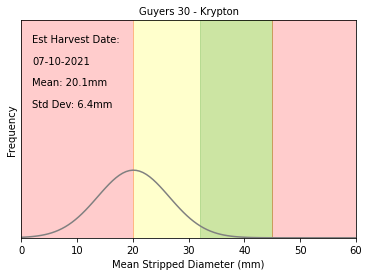

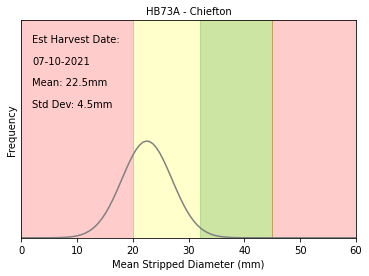

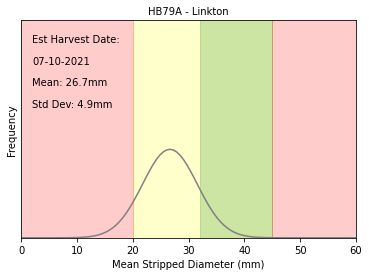

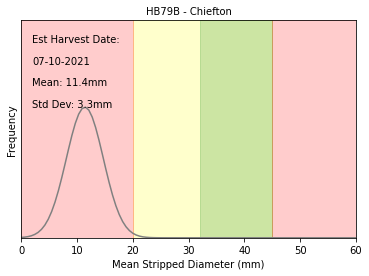

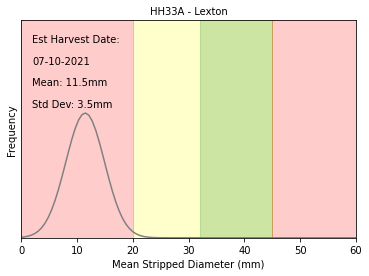

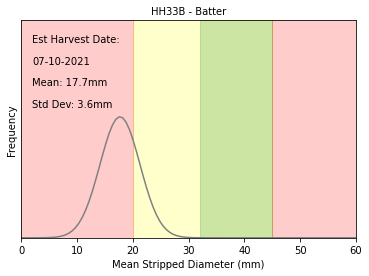

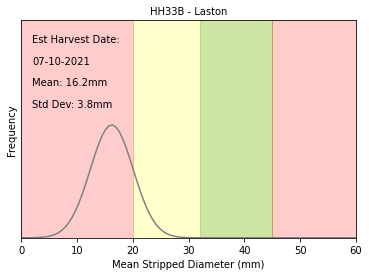

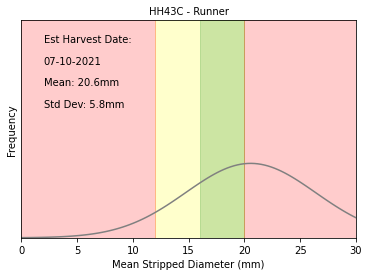

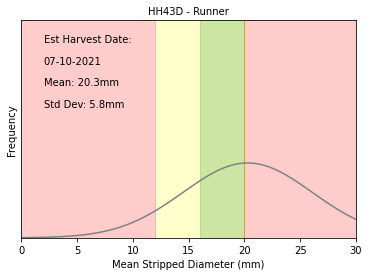

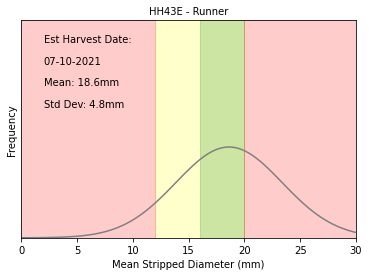

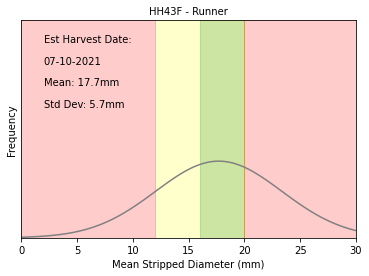

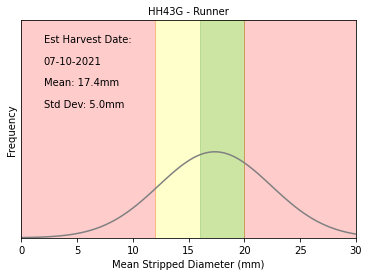

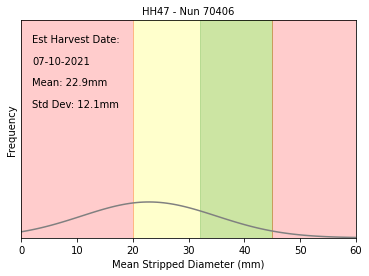

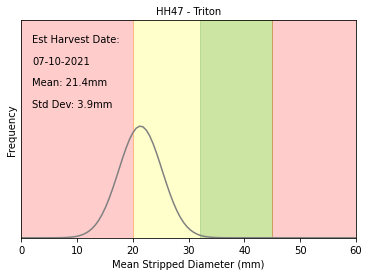

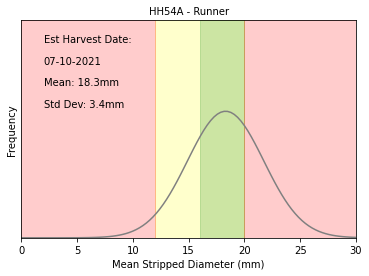

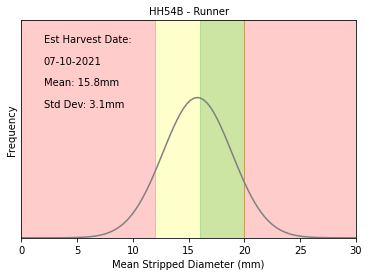

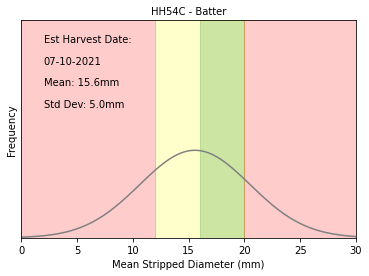

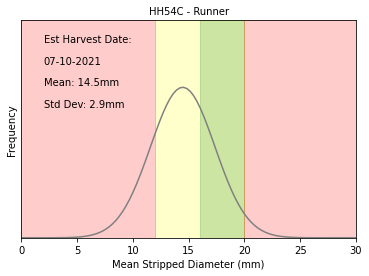

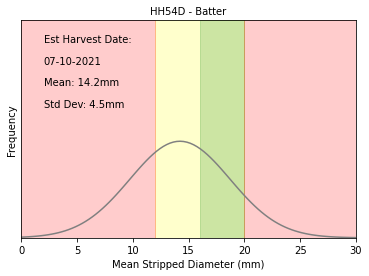

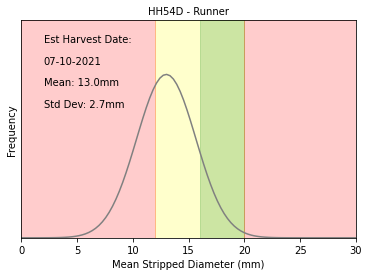

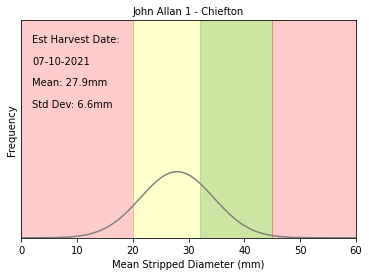

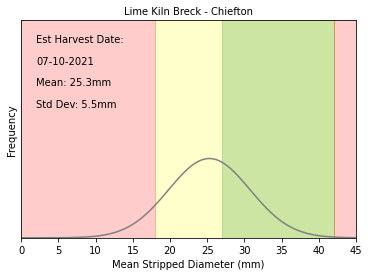

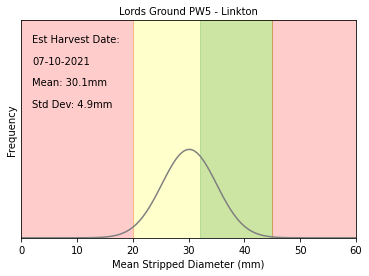

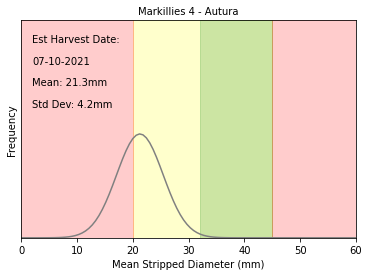

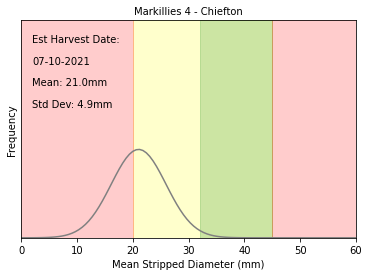

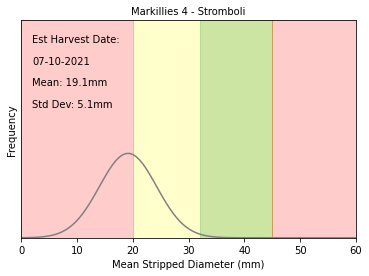

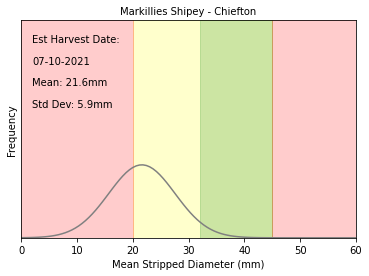

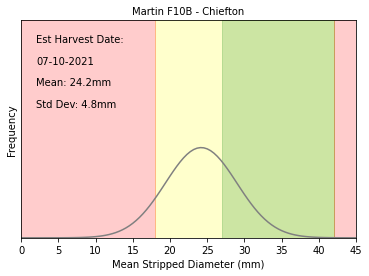

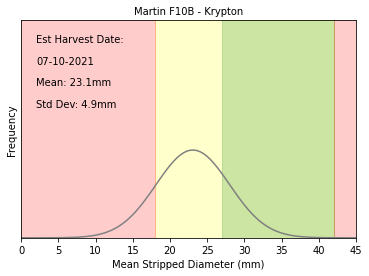

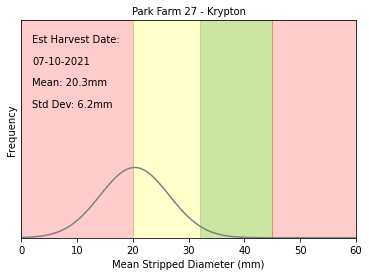

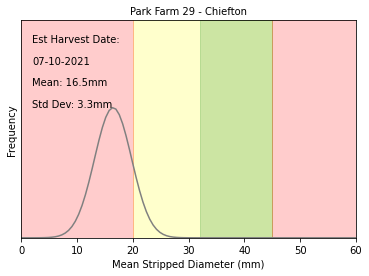

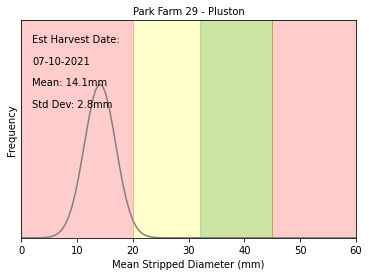

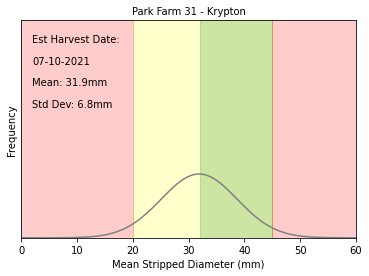

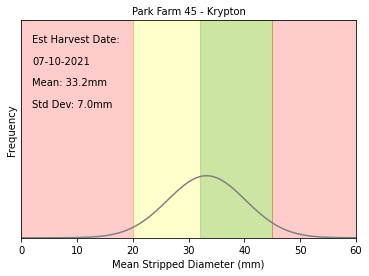

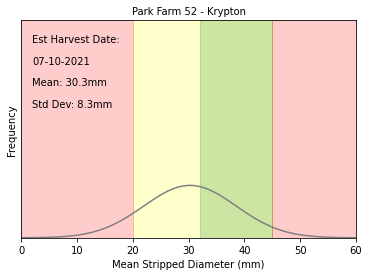

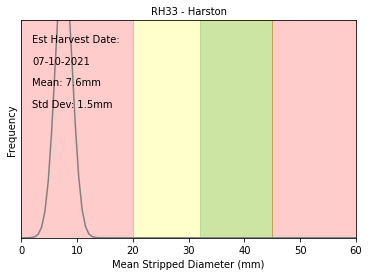

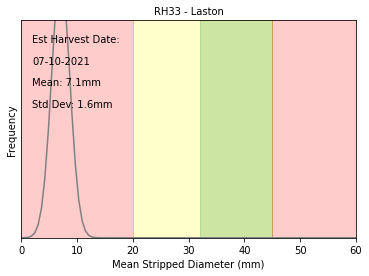

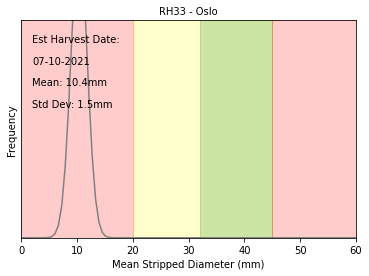

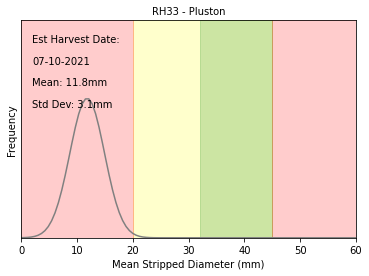

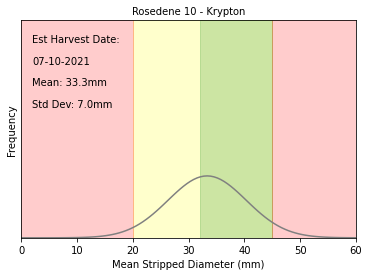

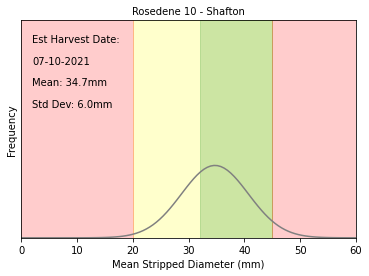

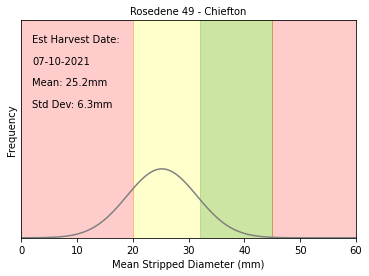

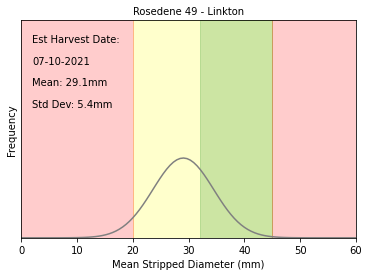

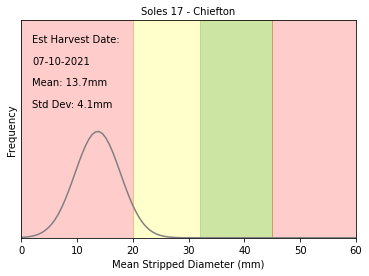

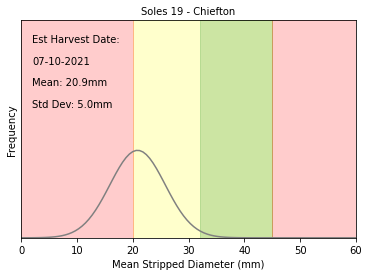

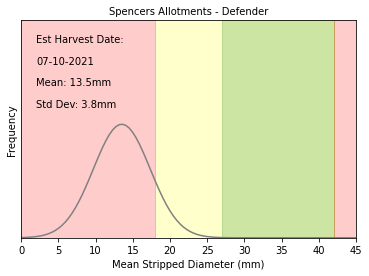

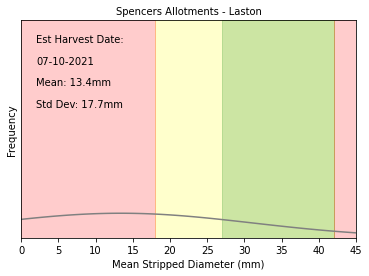

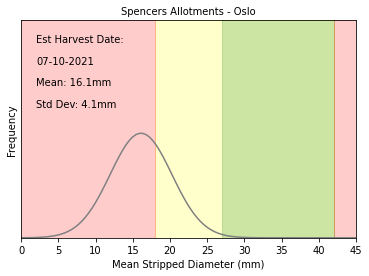

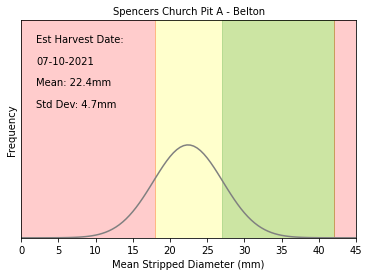

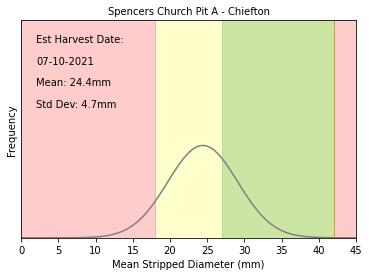

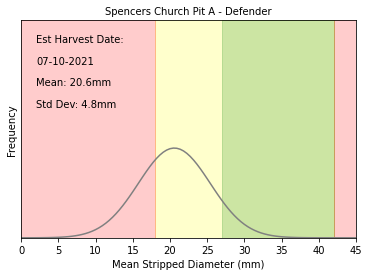

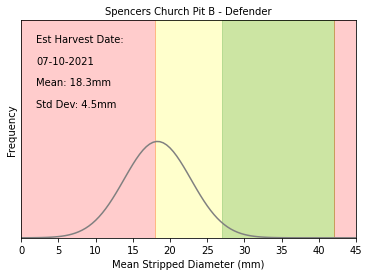

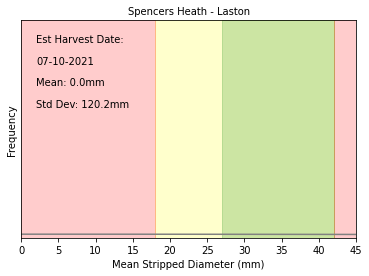

c:\users\tmccl\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\users\tmccl\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


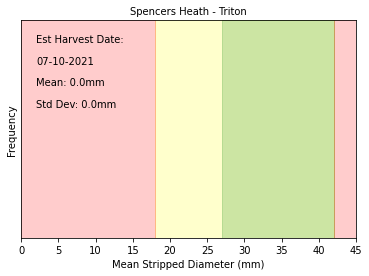

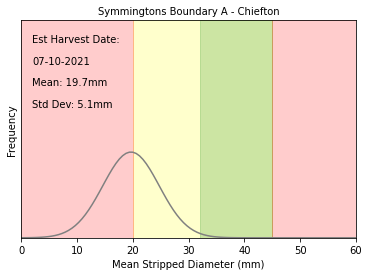

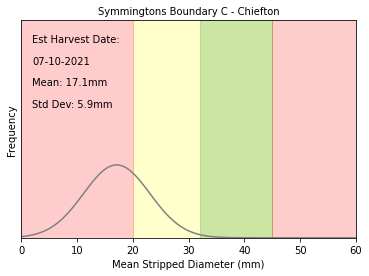

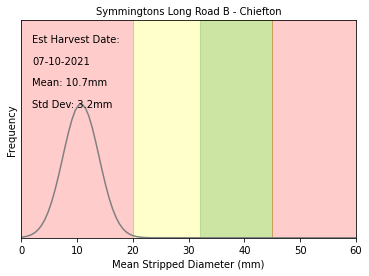

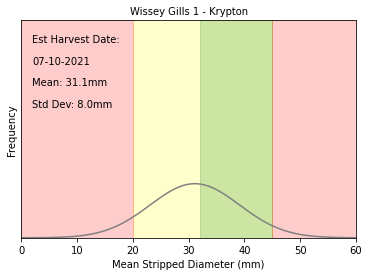

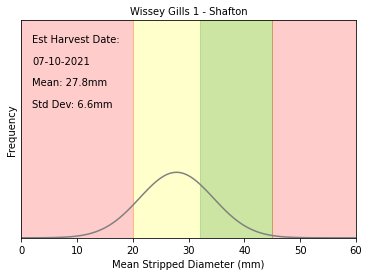

In [46]:
season = datetime(2021, 1, 1)
filt_zone_data = zone_data
filt_zone_data = filt_zone_data.loc[(filt_zone_data['planting_date'] > season)]
filt_zone_data = filt_zone_data.fillna(value = 0, axis = 1)
filt_zone_data = filt_zone_data.loc[(filt_zone_data['harvest_date'] == 0)]

field_variety_list = list(filt_zone_data['field_variety'])
field_variety_list = list(set(field_variety_list))
field_variety_list = sorted(field_variety_list)

for fv in field_variety_list:
    df = filt_zone_data.loc[(filt_zone_data['field_variety'] == fv)]
    df = df.reset_index(drop=True)
    inputs = mode(df['inputs'])
    
    
    if inputs == 'Baby':
        x_min = 0.0
        x_max = 30.0
        up_spec = 20
        low_spec = 12
        low_opt = 16
        
    elif inputs == 'Organic':
        x_min = 0.0
        x_max = 45.0
        up_spec = 42
        low_spec = 18
        low_opt = 27
        
    elif inputs == 'Conventional':
        x_min = 0.0
        x_max = 60.0
        up_spec = 45
        low_spec = 20
        low_opt = 32
        
    mean = df['est_mean_diameter'].mean()
    pooled_std = df['est_std_dev_diameter'].mean()
    
    ### Is this standard deviation calculation correct???
    ### No, but its as close as you'll get.
    
    ### NEED TO APPEND SD, MEAN AND FV VALUES TO DF AND EXPORT AT THE END AS CSV.

    x = np.linspace(x_min, x_max, 100)
    y = ss.norm.pdf(x,mean,pooled_std)
    c = 'grey'
    plt.plot(x,y, color=c)
    plt.grid()
    plt.xlim(x_min,x_max)
    plt.ylim(0,0.20)
    
    today = datetime.today()
    d = today + timedelta(days=7)
    d = d.strftime('%d-%m-%Y')
    
    plt.text(x=2, y=0.18, s='Est Harvest Date:')
    plt.text(x=2, y=0.16, s=d)
    plt.text(x=2, y=0.14, s=f'Mean: {mean:.1f}mm')
    plt.text(x=2, y=0.12, s=f'Std Dev: {pooled_std:.1f}mm')
    
    plt.grid(False)
    
    plt.axvspan(low_spec, up_spec, color='yellow', alpha=0.2)
    plt.axvspan(low_opt, up_spec, color='green', alpha=0.2)
    plt.axvspan(0, low_spec, color='red', alpha=0.2)
    plt.axvspan(up_spec, x_max, color='red', alpha=0.2)
    
    plt.title(f'{fv}',fontsize=10)
    
    new_fv = fv.replace('/', '-')

    plt.xlabel('Mean Stripped Diameter (mm)')
    plt.tick_params(left = False, labelleft = False)
    plt.ylabel('Frequency')
    plt.savefig(f"{cw_directory}//Distributions//{new_fv} Population Distribution.png",dpi=600)
    plt.show()